<a href="https://colab.research.google.com/github/eireford/ConwayLifeTensorFlow/blob/master/LTF_logistic_regression_two_step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import BatchNormalization

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
    '\n\nThis error most likely means that this notebook is not '
    'configured to use a GPU.  Change this in Notebook Settings via the '
    'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')
print(f"Found GPU at: {device_name}")

Found GPU at: /device:GPU:0


In [0]:
FEATURES_SHAPE = [1024,1024,1]
LABELS_SHAPE = [1024,1024,1]
SET_SIZE = 200

def random_uniform_grid(shape=FEATURES_SHAPE):
  return tf.round(tf.random.uniform(shape=shape,dtype=tf.float32))

In [0]:
def convolve_for_density_map(X):
  life_density_kernal = tf.constant([[[[1]],[[1]],[[1]]],
                                   [[[1]],[[10]],[[1]]],
                                   [[[1]],[[1]],[[1]]]],dtype=tf.float32)
  X_reshaped = tf.reshape(X,[1,X.shape[0],X.shape[1],1])
  density_map = tf.nn.conv2d(X_reshaped,life_density_kernal,[1,1,1,1],"SAME")
  density_map = tf.reshape(density_map,X.shape)
  return tf.round(density_map)

def will_be_alive(density_map):
  is_three = tf.equal(density_map,3.0)
  is_twelve = tf.equal(density_map,12.0)
  is_thirteen = tf.equal(density_map,13.0)
  any_true = is_three | is_twelve | is_thirteen
  return tf.cast(any_true,dtype=tf.float32)

def step(X):
  density_map = convolve_for_density_map(X)
  return will_be_alive(density_map)

In [0]:
def get_data_examples(size = SET_SIZE):
  for i in range(size):
    X = random_uniform_grid()
    Y1 = step(X)
    Y2 = step(Y1)
    yield X,Y2

def get_dataset():
  return tf.data.Dataset.from_generator(get_data_examples,(tf.float32,tf.float32),(tf.TensorShape(FEATURES_SHAPE),tf.TensorShape(LABELS_SHAPE)))
  
X_COMMON = get_dataset()

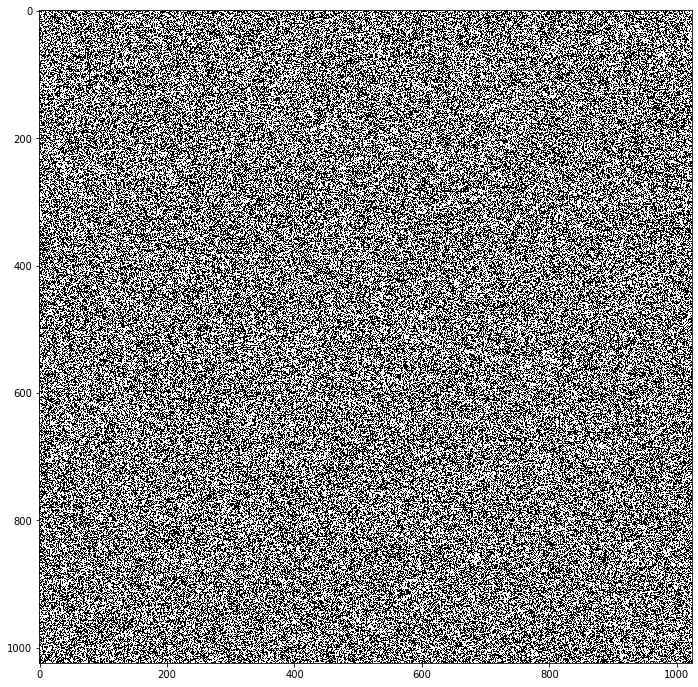

In [5]:
for element in X_COMMON: 
  e = element
  break
plt.gcf().set_size_inches(12,12)
figure_1 = plt.imshow(tf.squeeze(e[0]),cmap='Greys',origin='upper',interpolation='nearest')

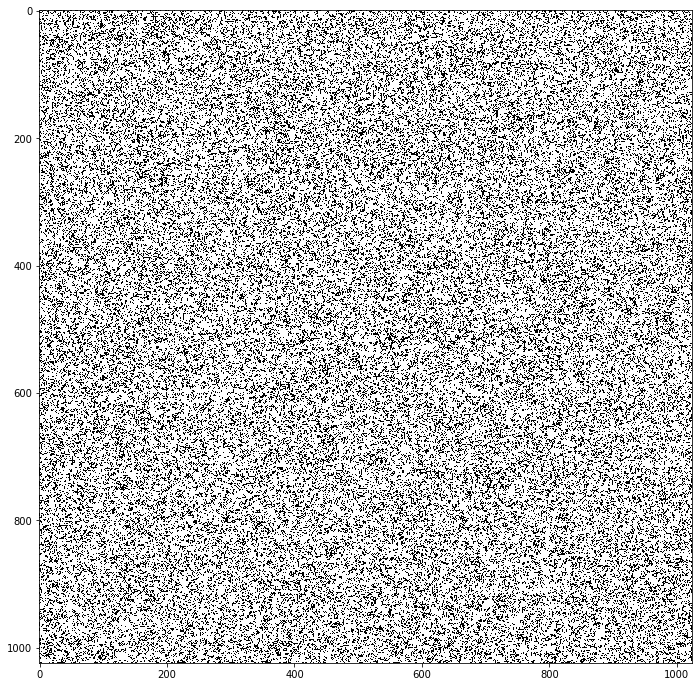

In [6]:
plt.gcf().set_size_inches(12,12)
figure_1 = plt.imshow(tf.squeeze(e[1]),cmap='Greys',origin='upper',interpolation='nearest')

In [0]:
ACCURACY_THRESHOLD = 0.99999

class myCallback(tf.keras.callbacks.Callback): 
 def on_epoch_end(self, epoch, logs={}): 
  if(logs.get('accuracy') > ACCURACY_THRESHOLD): 
    print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100)) 
    self.model.stop_training = True

callbacks = myCallback()

model = models.Sequential()
model.add(layers.Conv2D(16, (5, 5), padding='same',activation='relu', input_shape=FEATURES_SHAPE))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Conv2D(16, (3, 3), padding='same',activation='relu', input_shape=FEATURES_SHAPE))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(0.01,decay=1e-7),
              loss='mse',
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1024, 1024, 16)    416       
_________________________________________________________________
dense (Dense)                (None, 1024, 1024, 128)   2176      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1024, 1024, 16)    18448     
_________________________________________________________________
dense_1 (Dense)              (None, 1024, 1024, 128)   2176      
_________________________________________________________________
dense_2 (Dense)              (None, 1024, 1024, 1)     129       
Total params: 23,345
Trainable params: 23,345
Non-trainable params: 0
_________________________________________________________________


In [9]:
X_COMMON1 = X_COMMON.batch(2)
%time model.fit(X_COMMON1,epochs=20,callbacks=[callbacks])

Epoch 1/20
100/100 [==============================] - 20s 203ms/step - loss: 0.1719 - accuracy: 0.7470
Epoch 2/20
100/100 [==============================] - 20s 203ms/step - loss: 0.1313 - accuracy: 0.8001
Epoch 3/20
100/100 [==============================] - 20s 203ms/step - loss: 0.0865 - accuracy: 0.8759
Epoch 4/20
100/100 [==============================] - 20s 203ms/step - loss: 0.0174 - accuracy: 0.9811
Epoch 5/20
100/100 [==============================] - 20s 203ms/step - loss: 0.0013 - accuracy: 0.9989
Epoch 6/20
100/100 [==============================] - 20s 203ms/step - loss: 6.9982e-04 - accuracy: 0.9994
Epoch 7/20
100/100 [==============================] - 20s 203ms/step - loss: 1.6819e-04 - accuracy: 0.9999
Epoch 8/20
100/100 [==============================] - ETA: 0s - loss: 1.9074e-05 - accuracy: 1.0000
Reached 100.00% accuracy, so stopping training!!
100/100 [==============================] - 20s 203ms/step - loss: 1.9074e-05 - accuracy: 1.0000
CPU times: user 1min 21s, 

In [10]:
testset = get_dataset()
testset1 = testset.batch(10)
model.evaluate(testset1)

20/20 [==============================] - 8s 403ms/step - loss: 1.2167e-05 - accuracy: 1.0000


[1.2167031854914967e-05, 0.9999997615814209]